In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari

In [2]:
from skimage import data
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json

In [53]:
#Generate data directory
rootDir= 'For_testing'
dataDir = sep.join([rootDir,'raw','60D05_GCaMP8M_PB_Pilot'])
dataDir_sep = dataDir.split("/")
motionCorrectedDir= sep.join([rootDir,'motionCorrected',sep.join(dataDir_sep[-1:])])

In [54]:
image = tifffile.imread("Stack_2.tif")
print(image.shape)

(40, 9, 134, 302)


In [47]:
#import imglyb

In [48]:
#import imagej
#import scyjava
#scyjava.config.add_option('-Xmx6g')
#ij = imagej.init(mode='gui')

In [49]:
#%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
#%%classpath add mvn
#net.imagej imagej 2.0.0-rc-71
#net.imagej imagej-notebook 0.7.1

In [50]:
viewer = napari.Viewer()
new_layer = viewer.add_image(image)

In [10]:
viewer.dims.ndisplay = 3

In [11]:
print(image.shape)

(40, 9, 134, 302)


In [12]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])


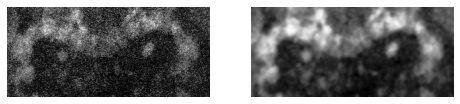

In [13]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
refImg = np.mean(stackMP[0:10,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


In [14]:
def computeMotionShift(stack, refImage, upsampleFactor, sigmaval = 2, doFilter = False, stdFactor = 2, showShiftFig = True):
    from skimage.registration import phase_cross_correlation

    if len(refImage.shape) == 3:
        print('perform motion correction on a volume')
        refImgFilt = refImage.copy()
        for p in range(stack['planes [µm]'].size):
            refImgFilt[p,:,:] = gaussian_filter(refImage[p,:,:], sigma=sigmaval)
        shift = np.zeros((2, stack['planes [µm]'].size,stack['volumes [s]'].size))
        error = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
        diffphase = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
    else:
        print('perform motion correction on a single plane/max projection')
        refImgFilt = gaussian_filter(refImage, sigma=sigmaval)

        shift = np.zeros((2, stack['volumes [s]'].size))
        error = np.zeros(stack['volumes [s]'].size)
        diffphase = np.zeros(stack['volumes [s]'].size)

    # compute shift
    for i in range(stack['volumes [s]'].size):
        if len(refImage.shape) == 3:
            for p in range(stack['planes [µm]'].size):
                shifImg = stack[i,p,:,:]
                shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

                # compute shift
                shift[:,p,i], error[p,i], diffphase[p,i] = phase_cross_correlation(refImgFilt[p,:,:].data, shifImgFilt,
                                                                             upsample_factor = upsampleFactor)
        else:
            shifImg = stack[i,:,:]
            shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

            # compute shift
            shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt,
                                                                         upsample_factor = upsampleFactor)
    if showShiftFig:
        if len(refImage.shape) == 3:
            fig, axs = plt.subplots(2,1,figsize=(15,6))
            axlab = ['x','y']
            for i, ax in enumerate(axs):
                ax.plot(shift[i,:].T)
                ax.set_xlabel('frames')
                ax.set_ylabel('image shift for {}'.format(axlab[i]))
        else:
            fig, ax = plt.subplots(1,1,figsize=(15,5))
            ax.plot(shift[0,:])
            ax.plot(shift[1,:])
            ax.set_xlabel('frames')
            ax.set_ylabel('image shift/pixel')

    if doFilter:
        shiftFilt_x = shift[0,:].copy()
        shiftFilt_y = shift[1,:].copy()
        shiftFilt_x[abs(shiftFilt_x) > stdFactor*np.std(shiftFilt_x)] = np.nan
        shiftFilt_y[abs(shiftFilt_y) > stdFactor*np.std(shiftFilt_y)] = np.nan

        allT = np.arange(len(shiftFilt_x))
        shiftFilt_x_interp = np.interp(allT, allT[~np.isnan(shiftFilt_x)], shiftFilt_x[~np.isnan(shiftFilt_x)])
        shiftFilt_y_interp = np.interp(allT, allT[~np.isnan(shiftFilt_y)], shiftFilt_y[~np.isnan(shiftFilt_y)])

        if showShiftFig:
            ax.plot(shiftFilt_x_interp,'b')
            ax.plot(shiftFilt_y_interp,'c')

        return np.vstack((shiftFilt_x_interp,shiftFilt_y_interp))
    else:
        return shift



perform motion correction on a single plane/max projection


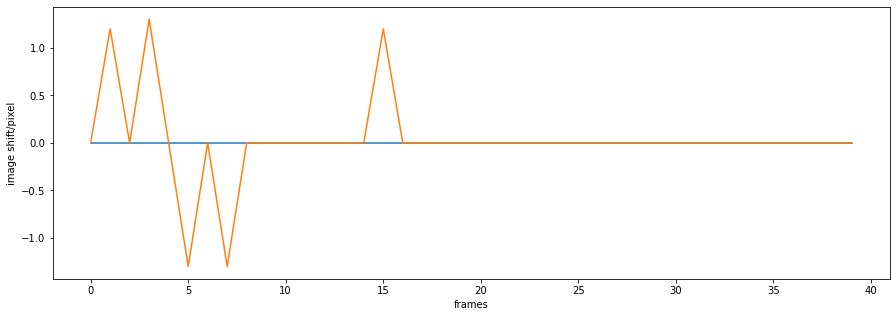

In [15]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [16]:
def motionCorrection(stack, shift):
    from scipy.ndimage import shift as spshift

    #check if shift was calculated for each plane in a volume separately, then check if stack to be aligned is 3d or 4d

    #stack should be an xarray
    stackMC = stack.copy()

    if len(shift.shape) == 3:
        # separate shifts for each plane in a volume
        if len(stack.shape) < 4:
            print("Imaging stack needs to be 4D.")
            return np.nan*stackMC
        for p in range(stack['planes [µm]'].size):
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,p,:,:]
                stackMC[i,p,:,:] = spshift(shifImg, shift[:,p,i], order=1,mode='reflect')

    else:
        #one shift per volume per time point
        if len(stack.shape) < 4:
            # motion correction on single plane or max projection
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,:,:]
                stackMC[i,:,:] = spshift(shifImg, shift[:,i], order=1,mode='reflect')
        else:
            #motion correction of 4D stack
            for v in range(stack["volumes [s]"].size):  #move one volume at a time
                tmpVol = stack[{"volumes [s]": v}]
                for p in range(tmpVol["planes [µm]"].size):
                    stackMC[v,p,:,:]  = spshift(tmpVol[p,:,:], shift[:,v], order=1,mode='reflect')

    return stackMC

In [17]:
stack4dMC = motionCorrection(imgStack, shift)

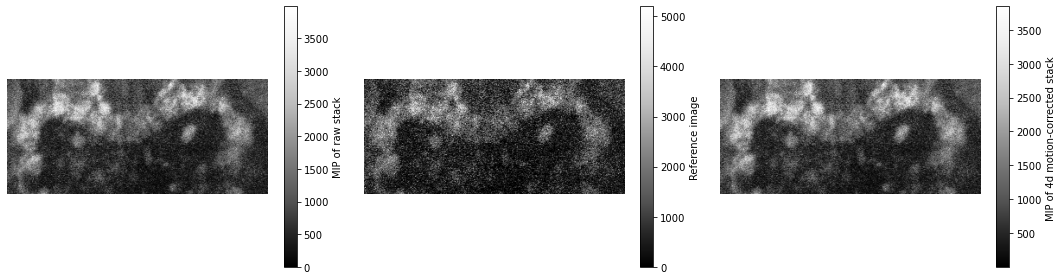

In [18]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [19]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [20]:
#viewer.layers.save('my_file.csv')

In [21]:
stack4dMC.shape

(40, 9, 134, 302)

In [22]:
label = tifffile.imread("Labels_16_Roi.tif")
viewer.add_labels(label, name='Labels_16_Roi')

<Labels layer 'Labels_16_Roi' at 0x7f21400fb160>

In [23]:
#Load ROI and label from napari
napari_roi_16 = viewer.layers['Labels_16_Roi'].data
napari_roi_16 = napari_roi_16[0,:,:,:]

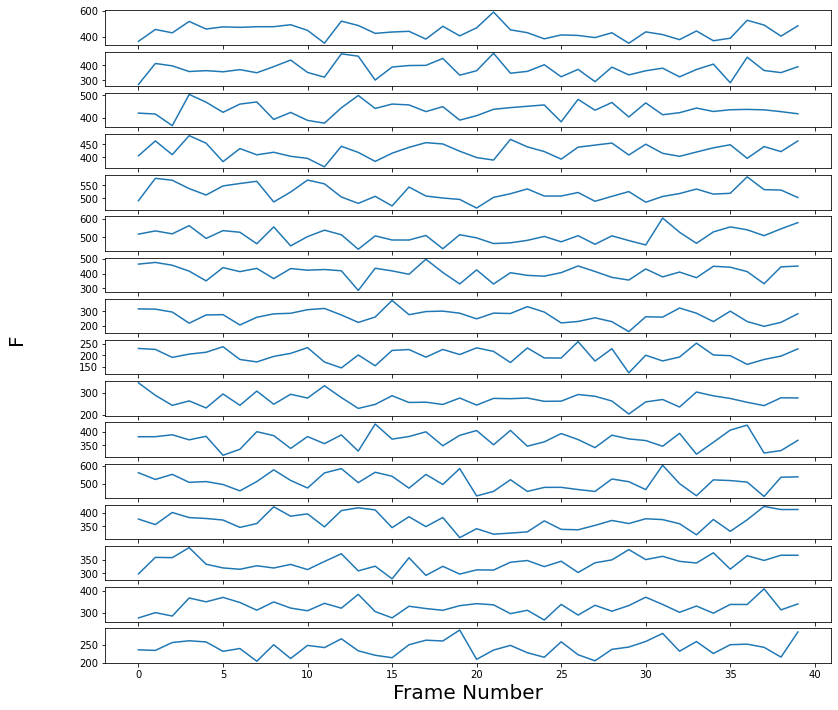

In [24]:
ROI_number = 16
F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
stack4dMC_numpy = stack4dMC.to_numpy()
for time_point in range(stack4dMC['volumes [s]'].size):
        current_volume = stack4dMC_numpy[time_point,:,:,:]
        for ROI_index in range(1, ROI_number + 1):
            mask = napari_roi_16 == ROI_index
            F_array[time_point, ROI_index - 1] =current_volume[mask].mean() 
            
fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(F_array[:,i])
fig.supylabel('F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()
    

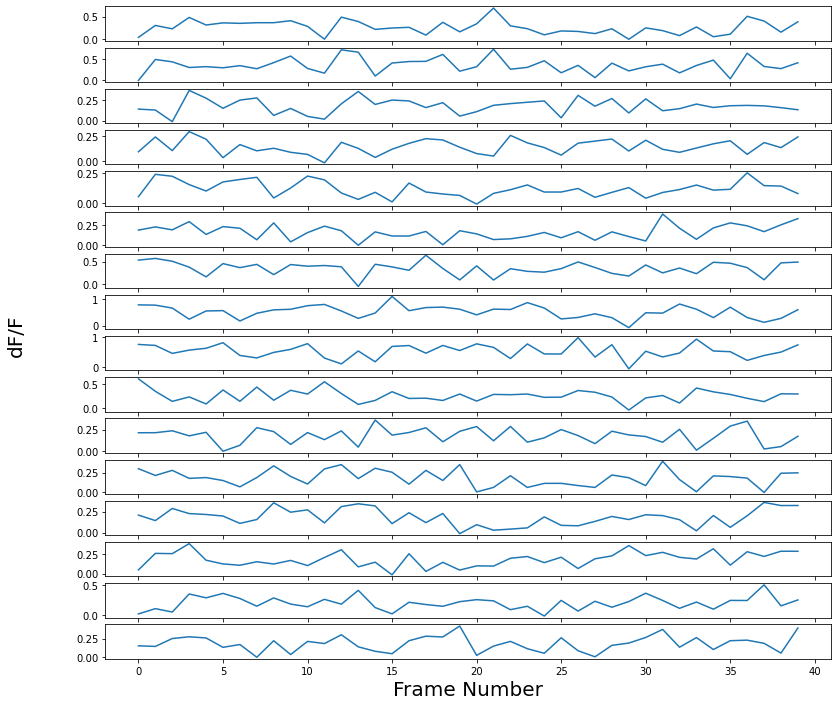

In [25]:
dF_F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_zero = np.quantile(F_array, 0.01, axis = 0)
for F_zero_index in range(ROI_number):
    dF_F_array[:,F_zero_index] = (F_array[:,F_zero_index] - F_zero[F_zero_index])/F_zero[F_zero_index]



fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(dF_F_array[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

<AxesSubplot:>

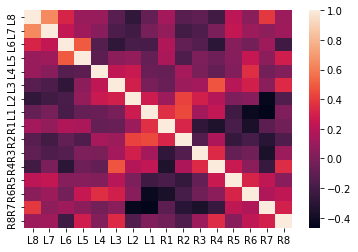

In [26]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe = pd.DataFrame(dF_F_array, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
sns.heatmap(correlation_matrix_df_f )

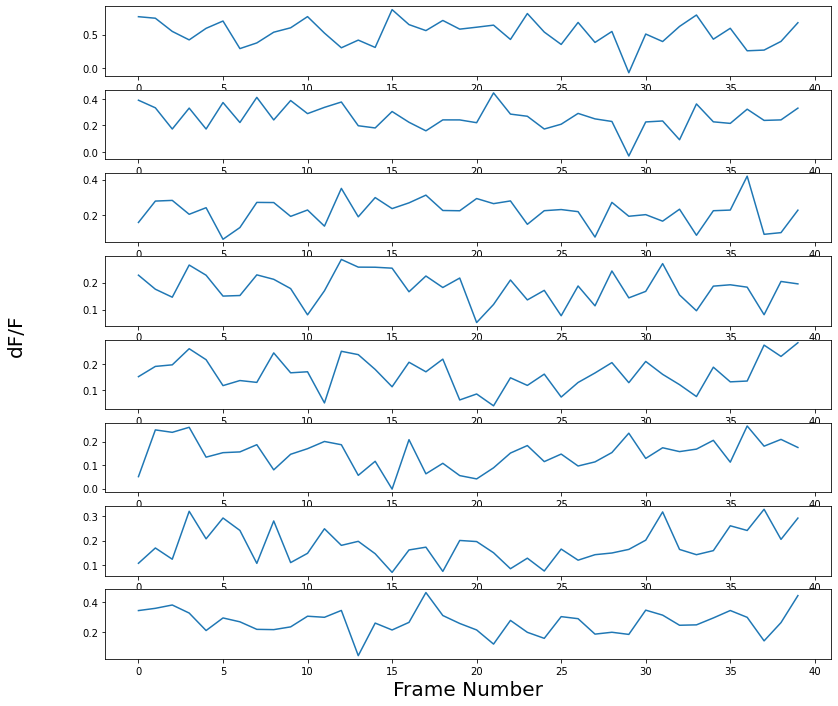

In [27]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
dF_F_array_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        dF_F_array_8_roi[:,0] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        dF_F_array_8_roi[:,combined_ROI_index + 1] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(dF_F_array_8_roi[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

In [146]:
#Calculate PVA
def PVA_radian_calcul (dff_array, frame_number, ROI_NUM):
    #Assign an angle-array for 8 ROIs ROI1(1R/1L)is0,  ROI2(2R/8L) is 45
    angle_array_roi_8 = [0,np.pi/4,np.pi/2,np.pi*3/4,np.pi,np.pi*5/4,np.pi*3/2,np.pi*7/4]
    #Define a polar 2 cartesian function 
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return x, y
    #Initialize PVA_array 
    PVA_radianArray = np.zeros(frame_number)
    
    for current_PVA_index in range(len(dff_array)):
        temp_x= np.zeros(ROI_NUM)
        temp_y= np.zeros(ROI_NUM)
        for current_ROI_index in range(ROI_NUM):
            temp_x[current_ROI_index], temp_y[current_ROI_index] = pol2cart(dff_array[current_PVA_index,current_ROI_index],angle_array_roi_8[current_ROI_index])
            x_value_PVA = sum(temp_x)
            y_value_PVA = sum(temp_y)
            PVA_radianArray[current_PVA_index] = np.arctan2(y_value_PVA , x_value_PVA )
    
    return PVA_radianArray

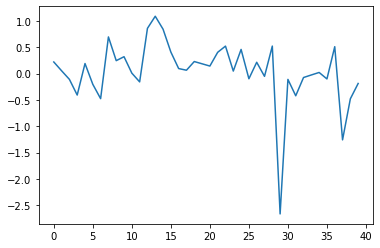

In [154]:
PVA_radian_array = PVA_radian_calcul(dF_F_array_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array)

In [149]:
import math
def PVA_radian_to_angle(PVA_radian):
    PVA_angle = np.zeros(PVA_radian.size)
    for current_frame in range(len(PVA_radian)):
        if PVA_radian[current_frame] >= 0:
            PVA_angle[current_frame] = math.degrees(PVA_radian[current_frame])
        else:
            PVA_angle[current_frame] = 360 + math.degrees(PVA_radian[current_frame])
    return PVA_angle

In [150]:
PVA_angle_Array = PVA_radian_to_angle(PVA_radian_array)
PVA_angle_Array[0]

12.679174561124078

In [151]:
def PVAangleToRoi (PVA_angle):
    PVA_ROI = np.zeros(PVA_angle.size)
    for current_frame in range(len(PVA_angle)):
        if 0 <= PVA_angle[current_frame] < 45:
            PVA_ROI[current_frame] = 0
        elif 45 <= PVA_angle[current_frame] < 90:
            PVA_ROI[current_frame] = 1
        elif 90 <= PVA_angle[current_frame] < 135:
            PVA_ROI[current_frame] = 2
        elif 135 <= PVA_angle[current_frame] < 180:
            PVA_ROI[current_frame] = 3
        elif 180 <= PVA_angle[current_frame] < 225:
            PVA_ROI[current_frame] = 4
        elif 225 <= PVA_angle[current_frame] < 270:
            PVA_ROI[current_frame] = 5
        elif 270 <= PVA_angle[current_frame] < 315:
            PVA_ROI[current_frame] = 6
        else:
            PVA_ROI[current_frame] = 7
            
    return PVA_ROI

In [152]:
PVA_ROI_assigned = PVAangleToRoi(PVA_angle_Array)
PVA_ROI_assigned

array([0., 0., 7., 7., 0., 7., 7., 0., 0., 0., 0., 7., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 7., 0., 7., 0., 4., 7., 7., 7., 7.,
       0., 7., 0., 6., 7., 7.])

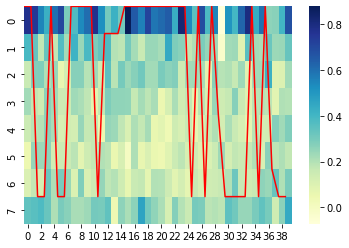

In [153]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
p1 = sns.heatmap(dF_F_array_8_roi.transpose(),cmap='YlGnBu')
p2 = sns.lineplot(data = PVA_ROI_assigned, color='red')
plt.show()

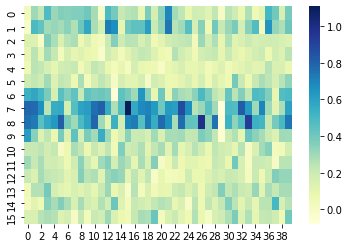

In [35]:
#Plot uncombined 16 ROi all together
p1 = sns.heatmap(dF_F_array.transpose(),cmap='YlGnBu')

In [36]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Downloads/TSeries-08122022-1422-007_Cycle00001_VoltageRecording_001.csv')

In [37]:
#Input5 = Heading, Input6 =x , Input7 =y

In [38]:
voltage_recording = voltage_recording.rename(columns={"Time(ms)":"time_ms", " Input 5": "Heading", " Input 6": "x_position", " Input 7": "y_position"})
voltage_recording 

,time_ms,Input 0,Input 1,Input 2,Input 3,Input 4,Heading,x_position,y_position
0,0.000,3.793945,0.028687,0.079346,0.005493,0.002747,0.338135,2.256165,0.659485
1,0.005,4.280090,0.014038,0.072632,3.315430,0.009460,0.338135,2.255249,0.659180
2,0.010,4.593811,0.014038,0.077820,3.315735,0.009460,0.338135,2.255859,0.659485
3,0.015,4.771423,0.014038,0.072632,3.316040,0.008850,0.338135,2.255859,0.659485
4,0.020,4.871521,0.014343,0.079041,3.314819,0.009155,0.337830,2.255859,0.660095
...,...,...,...,...,...,...,...,...,...
24006396,120031.980,0.017090,0.012817,0.078125,3.314514,0.000916,1.418457,1.516418,0.927734
24006397,120031.985,0.017395,0.013428,0.072632,3.314514,0.001221,1.418152,1.520081,0.929871
24006398,120031.990,0.017700,0.013428,0.077515,3.314209,0.001526,1.418762,1.517029,0.927124
24006399,120031.995,0.017395,0.013428,0.072021,3.315430,0.000916,1.418152,1.517639,0.927429


In [41]:
heading_array = voltage_recording ['Heading']

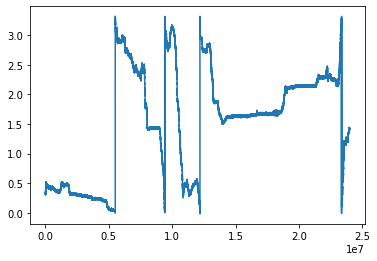

In [42]:
plt.plot(heading_array)

In [136]:
def fictrack_signal_decoding(unprocessed_heading):
    #Prepocessing the heading array for further analysis
    RadiansArray_heading = unprocessed_heading * np.pi * 2 / np.max(heading_array)
    unwrapped_heading = np.unwrap(RadiansArray_heading)
    
    #Find where is the big jump happening 
    upwrappedIndexes  = np.argwhere(np.absolute(np.diff(RadiansArray_heading)) > np.pi)
    NUM_SAMPLES_FROM_WRAP_TO_REPLACE = 2
    
    for i in range(len(upwrappedIndexes)):
        if upwrappedIndexes[i] < (NUM_SAMPLES_FROM_WRAP_TO_REPLACE -1) and upwrappedIndexes[i] > len(unwrapped_heading) - (NUM_SAMPLES_FROM_WRAP_TO_REPLACE+1):
            upwrappedIndexes.pop(i)
            i = i - 1
    
    #Repplace potentially problematic indexs with NaN\
    cleanedPos = unwrapped_heading
    for j in range(len(upwrappedIndexes)):
        index_start = upwrappedIndexes[j] - NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        index_end = upwrappedIndexes[j] + NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        cleanedPos[index_start[0]-1:index_end[0]] = np.NaN
        
        #Replace NaN values with the last preceding value that was a real number
        nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    while (len(nanIDX) > 0):
        cleanedPos[nanIDX] = cleanedPos[nanIDX-1]
        nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    cleanedPos = np.absolute(cleanedPos)
    
    plt.plot(cleanedPos)
    
    return cleanedPos

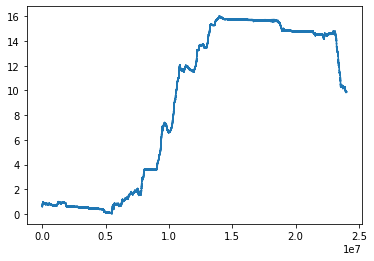

In [137]:
heading_array_processed = fictrack_signal_decoding(heading_array)